In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
import mlflow
from tqdm import tqdm 
from transformers import BertTokenizer, BertModel, BertForMaskedLM, BertForPreTraining
import torch

In [3]:
# Instantiate tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForMaskedLM.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
# Check default parameters
for param in model.parameters():
    print(param)
    break

Parameter containing:
tensor([[-0.0102, -0.0615, -0.0265,  ..., -0.0199, -0.0372, -0.0098],
        [-0.0117, -0.0600, -0.0323,  ..., -0.0168, -0.0401, -0.0107],
        [-0.0198, -0.0627, -0.0326,  ..., -0.0165, -0.0420, -0.0032],
        ...,
        [-0.0218, -0.0556, -0.0135,  ..., -0.0043, -0.0151, -0.0249],
        [-0.0462, -0.0565, -0.0019,  ...,  0.0157, -0.0139, -0.0095],
        [ 0.0015, -0.0821, -0.0160,  ..., -0.0081, -0.0475,  0.0753]],
       requires_grad=True)


In [5]:
text = pd.read_csv('../data/all_feedback_consolidated.csv')['Text_Eng'].drop_duplicates().tolist()

In [6]:
len(text)

9920

In [7]:
# Tokenize text
inputs = tokenizer(text, return_tensors='pt', max_length=512, truncation=True, padding='max_length')

In [8]:
# labels will be same as input, with random words being masked
inputs['labels'] = inputs.input_ids.clone().detach()

In [9]:
# create random array of floats with equal dimensions to input_ids tensor
rand = torch.rand(inputs.input_ids.shape)
# create mask array
mask_arr = (rand < 0.15) * (inputs.input_ids != 101) * \
           (inputs.input_ids != 102) * (inputs.input_ids != 0)

In [10]:
selection = []

for i in range(inputs.input_ids.shape[0]):
    selection.append(
        torch.flatten(mask_arr[i].nonzero()).tolist()
    )

In [11]:
# Convert selected words to masked (token 103)
for i in range(inputs.input_ids.shape[0]):
    inputs.input_ids[i, selection[i]] = 103

In [12]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings
    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
    def __len__(self):
        return len(self.encodings.input_ids)

In [13]:
dataset = Dataset(inputs)

In [14]:
loader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=True)

In [15]:
# activate training mode
model.train()

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In [16]:
from torch.optim import Adam
# initialize optimizer
optim = Adam(model.parameters(), lr=5e-5)

In [17]:
from tqdm import tqdm  # for our progress bar
batch_losses = []
epochs = 2

for epoch in range(epochs):
    # setup loop with TQDM and dataloader
    loop = tqdm(loader, leave=True)
    for batch in loop:
        # initialize calculated gradients (from prev step)
        optim.zero_grad()
        # pull all tensor batches required for training
        input_ids = batch['input_ids']#.to(device)
        attention_mask = batch['attention_mask']#.to(device)
        labels = batch['labels']#.to(device)
        # process
        outputs = model(input_ids, attention_mask=attention_mask,
                        labels=labels)
        
        # extract loss
        loss = outputs.loss
        # calculate loss for every parameter that needs grad update
        loss.backward()
        # update parameters
        optim.step()
        # print relevant info to progress bar
        loop.set_description(f'Train Epoch {epoch+1}')
        loop.set_postfix(loss=loss.item())
        batch_losses.append(loss.item())

  0%|                                                                                         | 0/1240 [00:00<?, ?it/s]<ipython-input-12-d87c8321e905>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Train Epoch 2: 100%|███████████████████████████████████████████████| 1240/1240 [6:21:33<00:00, 18.46s/it, loss=0.00609]


In [18]:
# Check that model weights have been updated
for param in model.parameters():
    print(param)
    break

Parameter containing:
tensor([[-0.0059, -0.0647, -0.0223,  ..., -0.0194, -0.0395, -0.0052],
        [-0.0161, -0.0565, -0.0363,  ..., -0.0175, -0.0377, -0.0146],
        [-0.0242, -0.0591, -0.0367,  ..., -0.0171, -0.0395, -0.0073],
        ...,
        [-0.0255, -0.0521, -0.0174,  ..., -0.0049, -0.0126, -0.0297],
        [-0.0502, -0.0526, -0.0060,  ...,  0.0151, -0.0111, -0.0148],
        [-0.0030, -0.0788, -0.0211,  ..., -0.0080, -0.0457,  0.0677]],
       requires_grad=True)


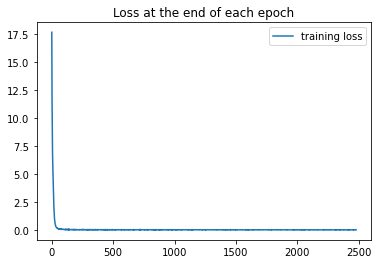

In [19]:
plt.plot(batch_losses, label='training loss')
plt.title('Loss at the end of each epoch')
plt.legend();

# Save tuned model

In [20]:
model.save_pretrained("../models/finetuned_bert/")
tokenizer.save_pretrained("../models/finetuned_bert/")

('../models/finetuned_bert/tokenizer_config.json',
 '../models/finetuned_bert/special_tokens_map.json',
 '../models/finetuned_bert/vocab.txt',
 '../models/finetuned_bert/added_tokens.json')